In [1]:
import argparse
import numpy as np

import torch

from utils import load_data,svdApprox,nmi_score
from GNN import GraphNeuralNet
import pycombo
import networkx as nx


import matplotlib.pyplot as plt 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)

In [4]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=20001,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.00001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=5,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [5]:
if 1:
    # Taxi Dataset Graph
    adj = load_data()
    #adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [6]:
def HGNN(adj,dim,fixed):
    
    #partition using pycombo
    G = nx.from_numpy_matrix(np.array(adj[0]))
    partition = pycombo.execute(G, random_seed = args.seed)
    
    #get binary matrix of the partition
    nb_community = max(list(partition[0].values())) + 1
    communities =  np.array(list(partition[0].values())).reshape(-1)
    C = np.eye(nb_community)[communities]
    
    #build the aggregated network
    adj_agg = np.matmul(np.matmul(np.transpose(C),adj[0]),C)
    adj_agg = torch.FloatTensor(adj_agg)
    adj_agg = adj_agg.unsqueeze(0)
    
    #initial embeds of aggregated network
    svd_mu, svd_sig, svd_loss, svdembedx, svdembedy = svdApprox(adj=adj_agg, dim=dim)
    aggfeatures = torch.cat((svdembedx, svdembedy), dim=1)
    if not fixed:
        aggsigma = svd_sig * torch.ones(aggfeatures.shape)
        aggfeatures = torch.cat([aggfeatures,aggsigma],dim=1)
    aggfeatures = aggfeatures.unsqueeze(dim=0)
    
    #run gnn on aggr network
    print("\nAggregated Network\n")
    
    if fixed:
        agg_embed, agg_sigma, agg_mu, agg_loss = GraphNeuralNet(adj=adj_agg, dim=dim, fixed=fixed, features=aggfeatures, agg=False)
    else:
        agg_embed, agg_mu, agg_loss = GraphNeuralNet(adj=adj_agg, dim=dim, fixed=fixed, features=aggfeatures, agg=False)
    
    agg_embed = agg_embed[0].detach().numpy()
    
    #perform svd on orig network
    _,sig,_,svd_embedx,svd_embedy = svdApprox(adj,dim)
    svd_embed = torch.cat([svd_embedx,svd_embedy],dim=1)
    if not fixed:
        svd_sigma = torch.ones(svd_embed.shape) * torch.sqrt(sig / dim)
        svd_embed = torch.cat([svd_embed,svd_sigma],dim=1)

    svd_embed = svd_embed.detach().numpy()
    
    #additional features to be added for disagg network
    if fixed:
        disagg_embed = agg_embed[communities]*np.absolute(svd_embed[:,:2*nb_community])/sum(np.absolute(svd_embed[:,:2*nb_community]).sum(axis=1))
        #combine svd embed with additional features above
        features = np.concatenate([svd_embed,disagg_embed],axis=1)
        features = torch.FloatTensor(features)
        features = features.unsqueeze(0)
    else:
        disagg_embed,disagg_sigma = np.split(agg_embed,2,axis=1)
        svd_embed,svd_sigma = np.split(svd_embed,2,axis=1)
        disagg_lr = disagg_embed[communities]*np.absolute(svd_embed[:,:2*nb_community])/sum(np.absolute(svd_embed[:,:2*nb_community]).sum(axis=1))
        disagg_sigma = disagg_sigma[communities]*np.absolute(svd_embed[:,:2*nb_community])/sum(np.absolute(svd_embed[:,:2*nb_community]).sum(axis=1))
        features_disagg = np.concatenate([svd_embed,svd_sigma],axis=1)
        features_agg = np.concatenate([disagg_lr,disagg_sigma],axis=1)
        features = np.concatenate([features_disagg,features_agg],axis=1)
        features = torch.FloatTensor(features)
        features = features.unsqueeze(0)
    
    
    #run gnn on disagg network
    print("\nDisaggregated Network\n")
    if fixed:
        embed, sigma, agg_embed, mu, loss = GraphNeuralNet(adj=adj, dim=dim, fixed=fixed, features=features, agg=True)
        return embed, sigma, agg_sigma, agg_embed, mu, loss
    else:
        embed, agg_embed, mu, loss = GraphNeuralNet(adj=adj, dim=dim, fixed=False, features=features, agg=True)
        return embed, agg_embed, mu, loss
    

In [7]:
def HGNN_embed(adj,dim):
    
    print("\nFixed Sigma dim {}\n".format(dim))
    
    disagg_lr,disagg_sig,agg_sigma,agg_lr,fix_mu,fix_loss = HGNN(adj,dim,True)

    disagg_sigma = torch.ones(disagg_lr.shape) * torch.sqrt(disagg_sig/dim)
    disagg_features = torch.cat([disagg_lr,disagg_sigma],dim=2)
    
    agg_sigma = torch.ones(agg_lr.shape) * torch.sqrt(agg_sigma/agg_lr.shape[2])
    agg_features = torch.cat([agg_lr,agg_sigma],dim=2)
    
    features = torch.cat([disagg_features,agg_features],dim=2)
    features = features.detach()

    print("\nFlexible Sigma dim {}\n".format(dim))
    embed, aggembed, flex_mu, flex_loss = GraphNeuralNet(adj=adj, dim=dim, fixed=False, features=features, agg=True)
    return embed, aggembed, fix_mu, flex_mu, fix_loss, flex_loss
    

In [8]:
fix_loss = []
nonfix_loss = []
svd_loss = []
svdrelu_loss = []
nmi_fix = []
nmi_nonfix = []
nmi_svd = []
nmi_svdrelu = []
dims = [x for x in range(1,15)]
for dim in dims:
    
    #fixembed, fixaggembed, fix_mu, flex_mu, fixloss, flexloss = HGNN_embed(adj,dim)
    print("\nFixed Sigma dim {}\n".format(dim))
    fixembed,fixsig,fixaggsigma,fixaggembed,fix_mu,fixloss = HGNN(adj,dim,True)
    print("\nFlexible Sigma dim {}\n".format(dim))
    flexembed,flexaggembed,flex_mu,flexloss = HGNN(adj,dim,False)
    fix_loss.append(fixloss)
    nmi_fix.append(nmi_score(adj[0],fix_mu.reshape(adj.shape[1:]).detach()))
    nonfix_loss.append(flexloss)
    nmi_nonfix.append(nmi_score(adj[0],flex_mu.reshape(adj.shape[1:]).detach()))
    
    mu,sig,loss,embedx,embedy = svdApprox(adj=adj,dim=dim)
    svd_loss.append(loss)
    nmi_svd.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    mu,sig,loss,embedx,embedy = svdApprox(adj=adj,dim=dim,relu=True)
    svdrelu_loss.append(loss)
    nmi_svdrelu.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))


Fixed Sigma dim 1


Aggregated Network

Epoch: 0001 loss: 17.00745773 time: 0.0016s
Epoch: 5001 loss: 17.00745583 time: 0.0000s
Epoch: 10001 loss: 17.00745583 time: 0.0000s
Epoch: 15001 loss: 17.00745583 time: 0.0000s
Epoch: 20001 loss: 17.00745583 time: 0.0000s
Optimization Finished!
Total time elapsed: 11.6122s

Disaggregated Network

Epoch: 0001 loss: 10.95440388 time: 0.0060s
Epoch: 5001 loss: 10.95440006 time: 0.0040s
Epoch: 10001 loss: 10.95440006 time: 0.0040s
Epoch: 15001 loss: 10.95440006 time: 0.0040s
Epoch: 20001 loss: 10.95440006 time: 0.0030s
Optimization Finished!
Total time elapsed: 79.4541s

Flexible Sigma dim 1


Aggregated Network

Epoch: 0001 loss: 33.01491547 time: 0.0010s
Epoch: 5001 loss: 31.46535110 time: 0.0000s
Epoch: 10001 loss: 17.34790230 time: 0.0010s
Epoch: 15001 loss: 17.34738922 time: 0.0000s
Epoch: 20001 loss: 17.34653473 time: 0.0010s
Optimization Finished!
Total time elapsed: 12.4287s

Disaggregated Network

Epoch: 0001 loss: 10.95440388 time: 0.0060

Epoch: 5001 loss: 6.69935274 time: 0.0030s
Epoch: 10001 loss: 6.69935274 time: 0.0060s
Epoch: 15001 loss: 6.69935274 time: 0.0050s
Epoch: 20001 loss: 6.69935274 time: 0.0060s
Optimization Finished!
Total time elapsed: 99.3009s

Fixed Sigma dim 8


Aggregated Network

Epoch: 0001 loss: 2.55053759 time: 0.0000s
Epoch: 5001 loss: 2.55053759 time: 0.0030s
Epoch: 10001 loss: 2.55053759 time: 0.0000s
Epoch: 15001 loss: 2.55053759 time: 0.0041s
Epoch: 20001 loss: 2.55053759 time: 0.0000s
Optimization Finished!
Total time elapsed: 11.9304s

Disaggregated Network

Epoch: 0001 loss: 9.81505585 time: 0.0040s
Epoch: 5001 loss: 9.58837795 time: 0.0030s
Epoch: 10001 loss: 9.57528877 time: 0.0040s
Epoch: 15001 loss: 9.56907082 time: 0.0040s
Epoch: 20001 loss: 9.56516361 time: 0.0040s
Optimization Finished!
Total time elapsed: 80.3992s

Flexible Sigma dim 8


Aggregated Network

Epoch: 0001 loss: 5.70224237 time: 0.0000s
Epoch: 5001 loss: 5.70200682 time: 0.0000s
Epoch: 10001 loss: 5.70191336 time: 0.

Epoch: 5001 loss: 5.70200682 time: 0.0000s
Epoch: 10001 loss: 5.70191336 time: 0.0000s
Epoch: 15001 loss: 5.70187807 time: 0.0000s
Epoch: 20001 loss: 5.70187807 time: 0.0040s
Optimization Finished!
Total time elapsed: 11.9476s

Disaggregated Network

Epoch: 0001 loss: 9.40327168 time: 0.0080s
Epoch: 5001 loss: 5.78853226 time: 0.0040s
Epoch: 10001 loss: 5.78853226 time: 0.0061s
Epoch: 15001 loss: 5.78853226 time: 0.0080s
Epoch: 20001 loss: 5.78853226 time: 0.0040s
Optimization Finished!
Total time elapsed: 97.8028s


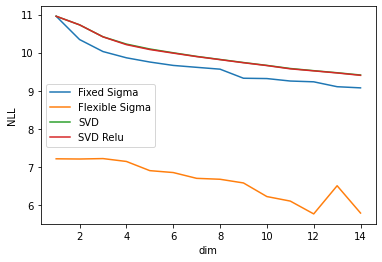

In [9]:
plt.plot(dims,fix_loss,label="Fixed Sigma")
plt.plot(dims,nonfix_loss,label="Flexible Sigma")
plt.plot(dims,svd_loss,label="SVD")
plt.plot(dims,svdrelu_loss,label="SVD Relu")
plt.xlabel("dim")
plt.ylabel("NLL")
plt.legend()